<a href="https://colab.research.google.com/github/Beatriz-Yun/AIFFEL_LMS/blob/main/Exploration/%5BE-06%5D2019Kaggle%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 학습 목표
- 데이터 사이언스 관련 최대 커뮤니티인 캐글의 경진대회에 직접 참여해서 문제를 해결해본다.
- 캐글에서 데이터를 내려받는 것으로부터 시작해서, 로컬 서버에서 자유롭게 다루어보며 문제 해결을 위한 고민을 해본다.
- 앙상블 기법의 개념과 강점을 이해하고, 여러 모델의 예측 결과를 Averaging 한 최종 결과로 캐글에 제출해본다.
- 하이퍼 파라미터 튜닝의 필요성과 의미를 이해하고, Grid Search, Random Search 등의 기법을 알아본다.
- Grid Search 기법을 활용해서 직접 하이퍼 파라미터 튜닝 실험을 해보고, 모델의 성능을 최대한 끌어올려본다.

<br>

---

<br>

이번 노드에서는 **회귀 모델을 구현**하는 데에 사용하는 **xgboost**와 **lightgbm** 라이브러리와, **결측 데이터를 확인**하는 **missingno** 라이브러리가 필요합니다.<br><br>
**pip list | grep 라이브러리명** 명령어를 통해 설치 여부를 확인한다.

In [ ]:
!pip list | grep xgboost
!pip list | grep lightgbm
!pip list | grep missingno
!pip list | grep scikit-learn

xgboost                       0.90
lightgbm                      2.2.3
missingno                     0.5.0
scikit-learn                  0.22.2.post1


실습을 진행할 Kaggle대회 링크<br>
--> [Kaggle 코리아와 함께하는 2nd ML 대회 - House Price Prediction](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)

<br>

캐글에는 아주 다양한 경진대회들이 있고, 각 경진대회들은 모두 대회 소개, 데이터셋 소개, 규칙 설명 등 대회에 참가하는 사람들을 위한 세부 내용들로 구성되어 있다.

이번 대회의 **평가기준은 RMSE**이다.
> RMSE는 Root Mean Squared Error 의 약자이며, 수식은 다음과 같다. $${\sqrt{ {1 \over N} \sum{(y_t - y_{pr})}^2}} $$
이는 실제 정답과 예측한 값의 차이의 제곱을 평균한 값의 제곱근이다.

이번 대회에서 다루는 문제는 **"집값"을 예측하는 문제(회귀문제)**이기 때문에 우리가 예측해야 하는 값과 실제 정답값이 모두 실숫값이다. 따라서 RMSE가 합리적인 평가 척도이다.

# 1) 데이터 살펴보기

**Data fields**
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 집의 가격(Target variable)
4. bedrooms : 침실의 수
5. bathrooms : 화장실의 수
6. sqft_living : 주거 공간의 평방 피트(면적)
7. sqft_lot : 부지의 평방 피트(면적)
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트(면적)
14. sqft_basement : 지하실의 평방 피트(면적)
15. yr_built : 지어진 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

👉 우리가 예측해야 되는 값은 'price'이다.

# 2) Baseline 모델 
대회에서 baseline은 제공될 수도 안 될 수도 있다.

[2019 ML month 2nd baseline 커널](https://www.kaggle.com/kcs93023/2019-ml-month-2nd-baseline) ----> 이 파일을 가져와서 실행해보자.

## 2-2) Baseline 셋팅하기

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 2-3) 라이브러리, 데이터 가져오기

라이브러리 import하기

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

데이터 가져오기

In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data'

train_data_path = join(base_path, 'train.csv')
sub_data_path = join(base_path, 'test.csv')

print(train_data_path)
print(sub_data_path)

/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data/train.csv
/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data/test.csv


## 2-3) 데이터 이해하기

### 데이터 불러오기
- data ---> train.csv 파일의 데이터
- sub ---> test.csv 파일의 데이터

In [ ]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6555, 20)


### 학습 데이터에서 라벨 제거하기
- 이번 문제에서 라벨은 price칼럼이다. -----> 변수 y에 저장 후 칼럼을 제거

In [ ]:
print(data.columns)

y = data['price']

#del data['price']   # drop과 같은 동작
data.drop(columns='price', inplace=True)

print(data.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### 학습 데이터와 테스트 데이터 합치기
전체 데이터를 탐색해보기 위해 두 데이터를 합친다.<br>
나중에 다시 분리하기 위해 각 데이터의 길이를 저장해놓는다.

In [ ]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))   # train데이터 15035개와 test데이터 6555개를 더한 값과 같다. 

21590


In [ ]:
data.head(10)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,5,20150403T000000,3,2.50,3560,9796,1.0,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
6,6,20140527T000000,2,1.00,1160,6000,1.0,0,0,4,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000
7,7,20140528T000000,3,1.00,1430,19901,1.5,0,0,4,7,1430,0,1927,0,98028,47.7558,-122.229,1780,12697
8,8,20141007T000000,3,1.75,1370,9680,1.0,0,0,4,7,1370,0,1977,0,98074,47.6127,-122.045,1370,10208
9,9,20150312T000000,5,2.00,1810,4850,1.5,0,0,3,7,1810,0,1900,0,98107,47.6700,-122.394,1360,4850


### 간단한 전처리
- 결측치와 전체 데이터의 분포를 확인한다.

<br>

**1. 결측치 확인**

**missingno 라이브러리의 matrix함수**를 사용해서 데이터의 결측 상태를 시각화한다.

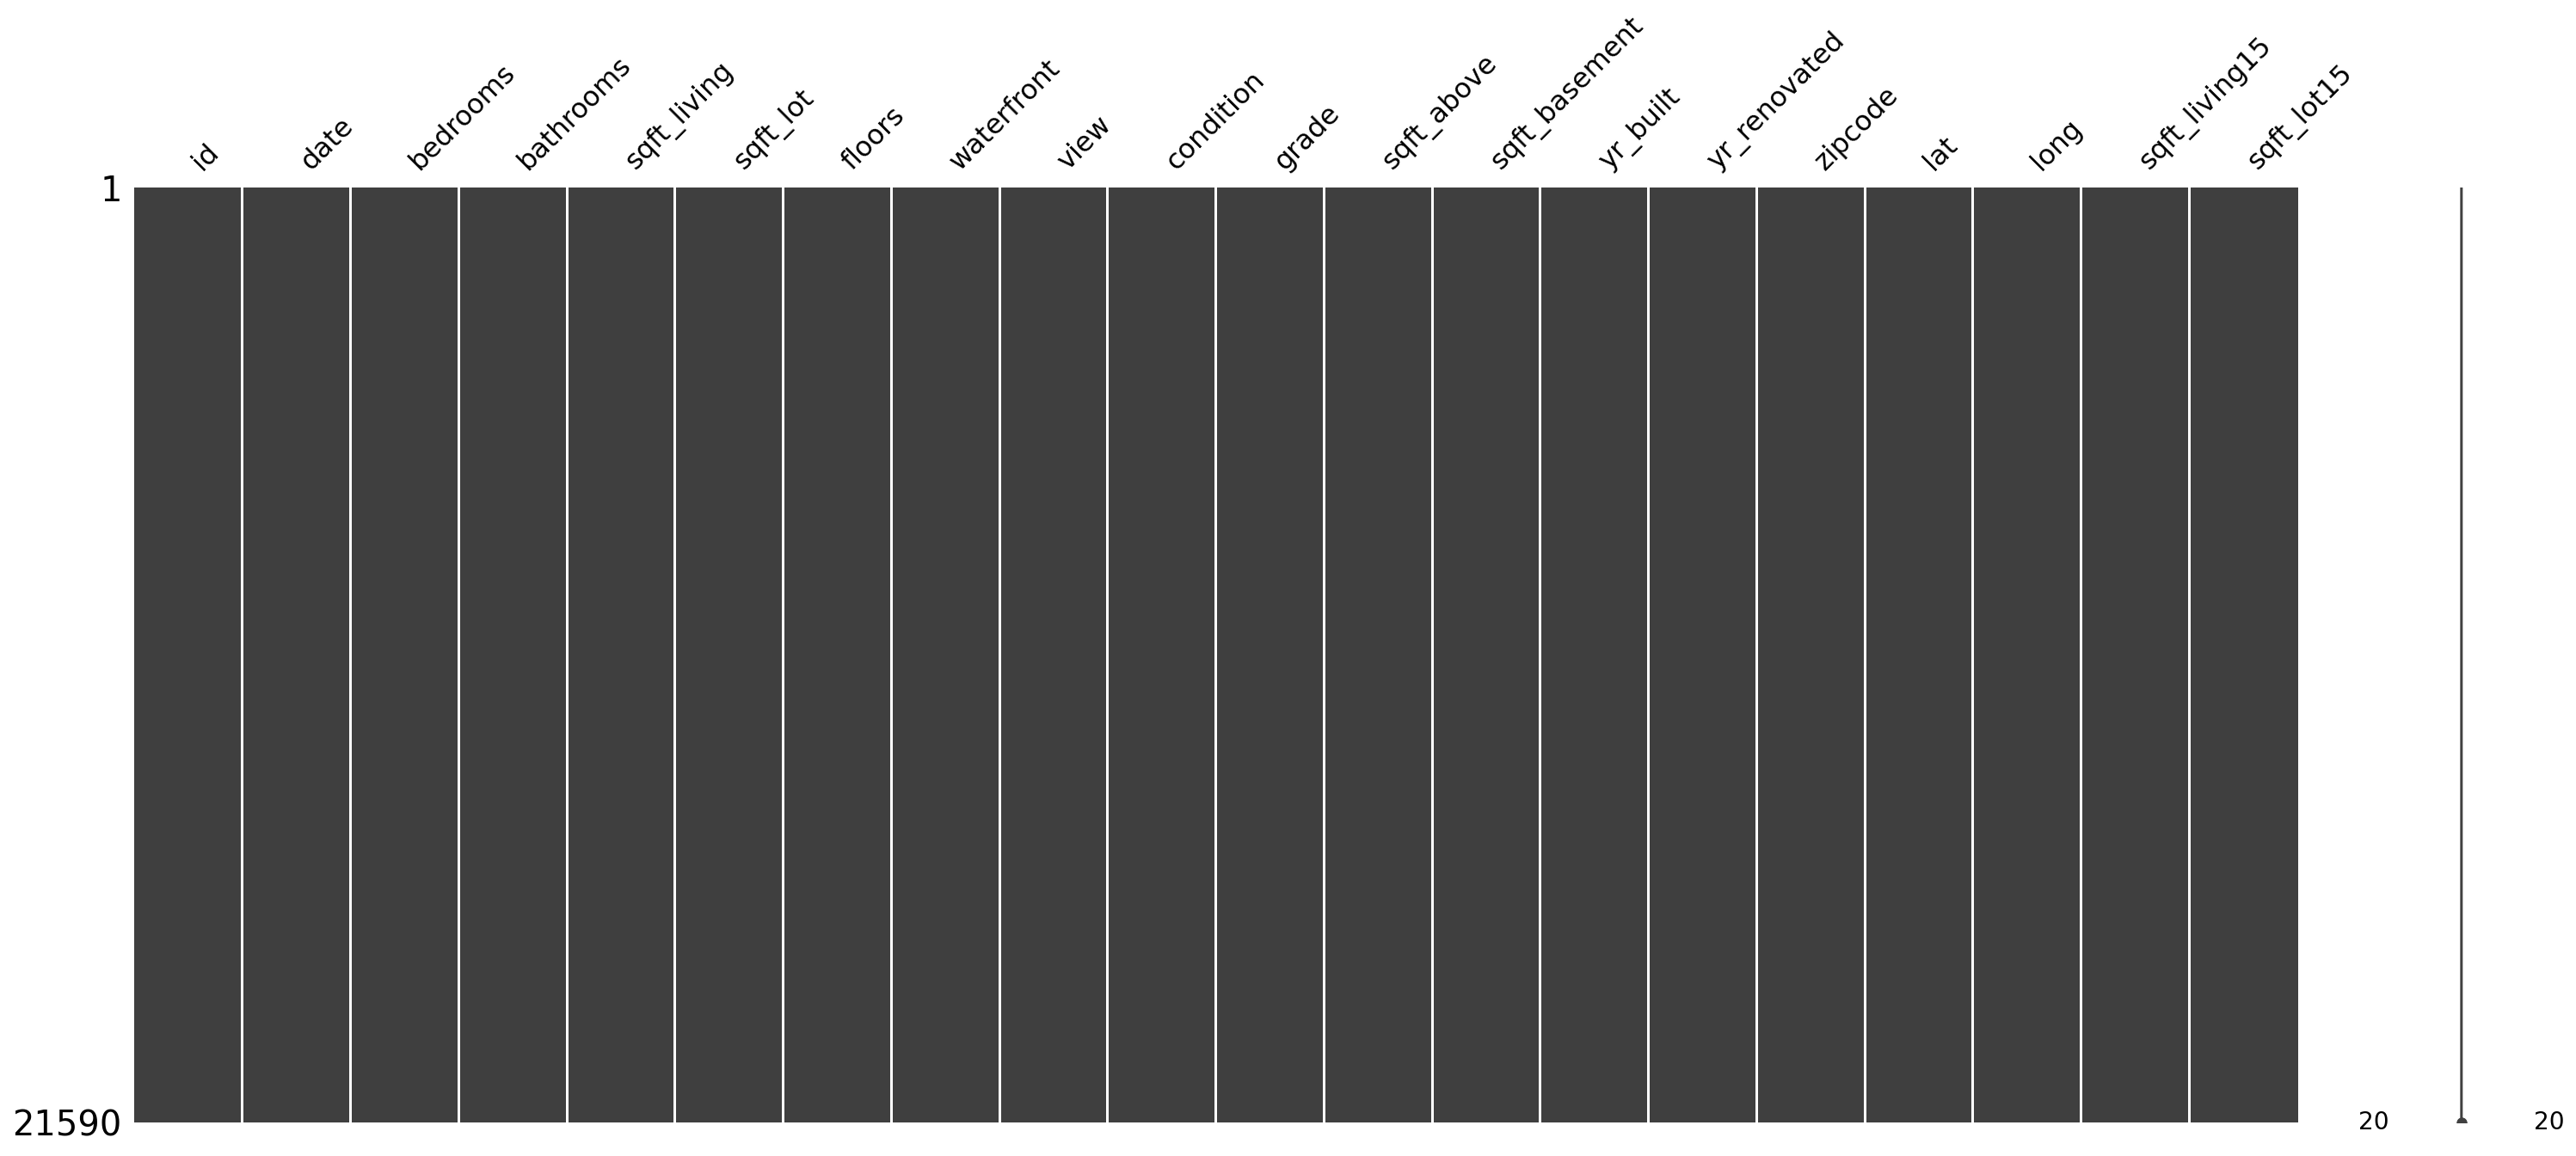

In [ ]:
msno.matrix(data)

pandas의 **isnull함수**를 사용해 다시한번 확인한다.

In [ ]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


**2. id, date 칼럼 처리**
- id칼럼은 집값을 예측하는데 도움을 주지 않으므로 제거한다.

In [ ]:
sub_id = data['id'][train_len:]   # test데이터의 'id'값 모두 가져오기
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- date변수는 연월일시간의 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만든다.

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


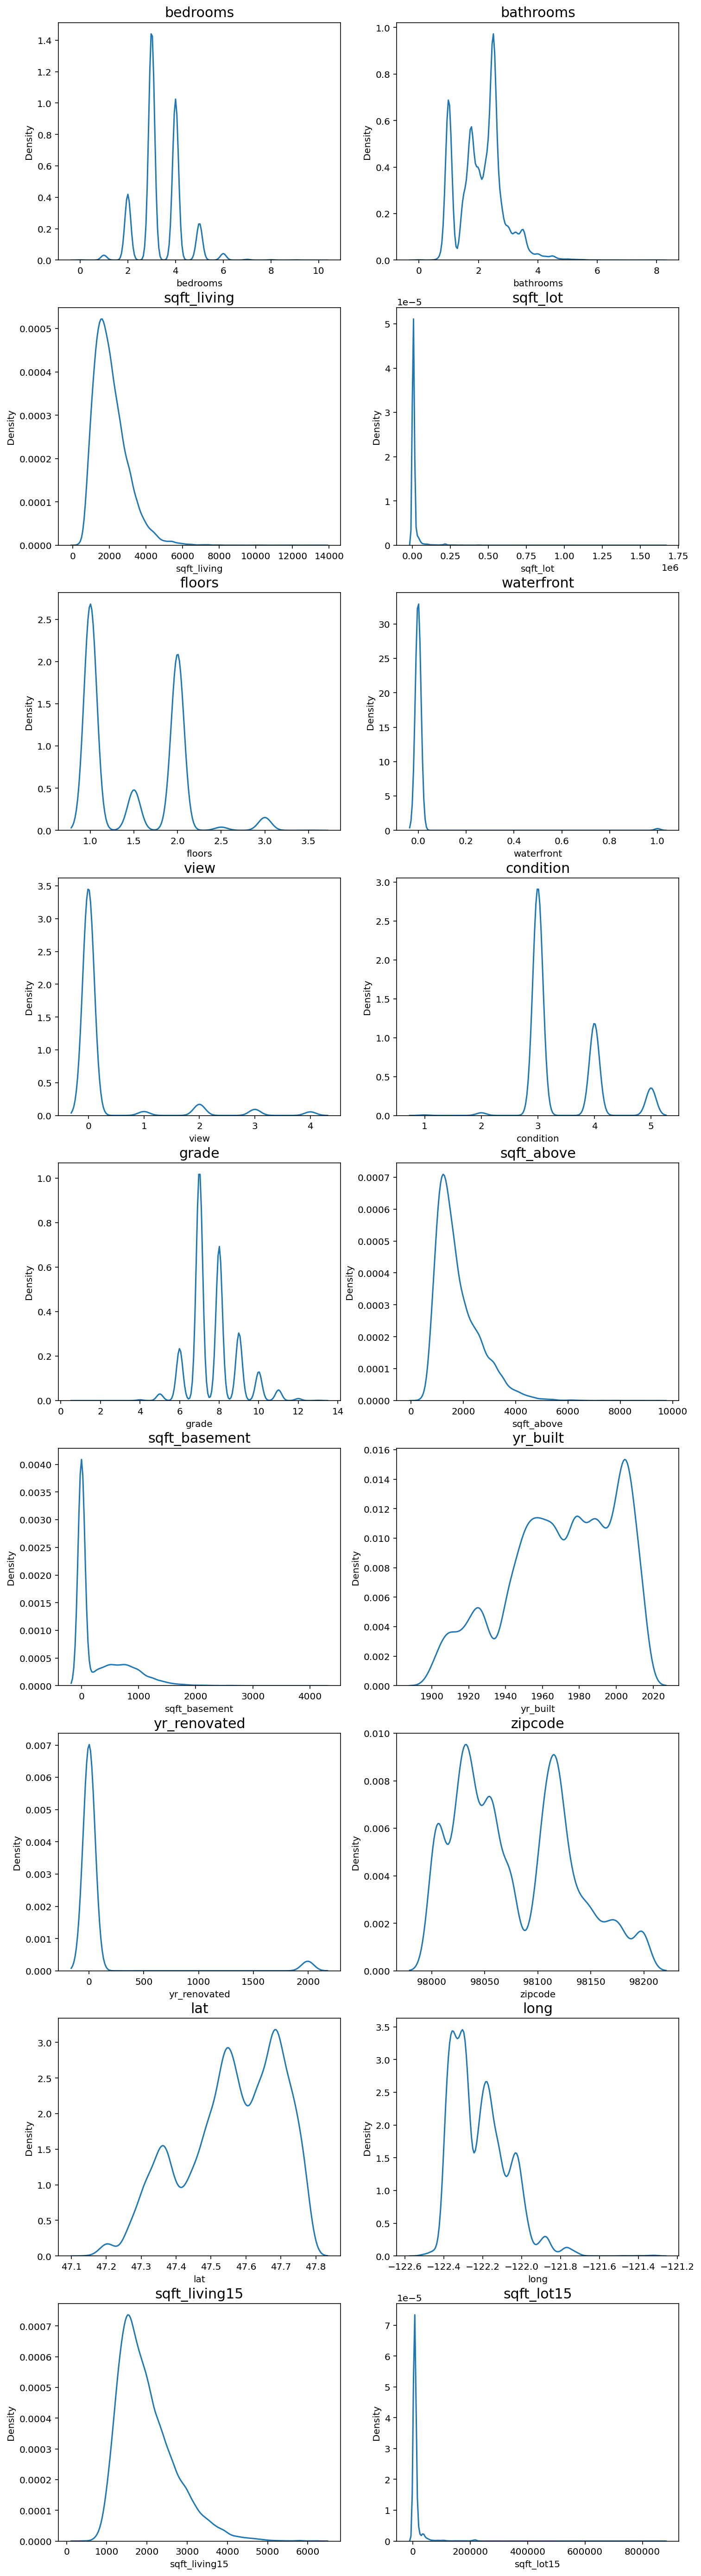

In [ ]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# date 변수(count==0인 경우)는 제외하고 분포를 확인한다.
count = 1
columns = data.columns
print(columns)

for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])     # count번째 칼럼에 있는 데이터에 대한 kde그래프를 그린다.
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break